### Prepare the workspace

In [1]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.1.2
True


In [2]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image

### Load the data

Here I'll use `torchvision` to load the already downloaded data.

### Data Description
The dataset is split into three parts, training, validation, and testing. For the training, I'll  apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I don't want any scaling or rotation transformations, but I'll need to resize then crop the images to the appropriate size.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = '/kaggle/input/flower-data-set/flowers/flowers' 
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


validation_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [6]:
images.shape

torch.Size([64, 3, 224, 224])

#### Label mapping

I'll also need to load in a mapping from category label to category name. It's in a file named `cat_to_name.json`. It's a JSON object which I'll read with the [`json` module](https://docs.python.org/2/library/json.html). This will give me a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
with open('/kaggle/input/flower-data-set/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

## Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. I'll use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

When training I'll be  updating only the weights of the feed-forward network.

In [ ]:
# Build and train network
model = models.densenet121(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth

100%|██████████| 30.8M/30.8M [00:00<00:00, 87.6MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 256)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device);

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            validation_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    validation_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {validation_loss/len(validloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 4.615.. Test loss: 4.512.. Test accuracy: 0.062

Epoch 1/1.. Train loss: 4.407.. Test loss: 4.399.. Test accuracy: 0.044

Epoch 1/1.. Train loss: 4.297.. Test loss: 4.316.. Test accuracy: 0.124

Epoch 1/1.. Train loss: 4.353.. Test loss: 4.182.. Test accuracy: 0.130

Epoch 1/1.. Train loss: 4.244.. Test loss: 4.067.. Test accuracy: 0.227

Epoch 1/1.. Train loss: 4.133.. Test loss: 3.961.. Test accuracy: 0.193

Epoch 1/1.. Train loss: 4.017.. Test loss: 3.821.. Test accuracy: 0.245

Epoch 1/1.. Train loss: 3.754.. Test loss: 3.650.. Test accuracy: 0.256

Epoch 1/1.. Train loss: 3.693.. Test loss: 3.502.. Test accuracy: 0.251

Epoch 1/1.. Train loss: 3.665.. Test loss: 3.381.. Test accuracy: 0.315

Epoch 1/1.. Train loss: 3.410.. Test loss: 3.226.. Test accuracy: 0.375

Epoch 1/1.. Train loss: 3.438.. Test loss: 3.076.. Test accuracy: 0.394

Epoch 1/1.. Train loss: 3.321.. Test loss: 2.911.. Test accuracy: 0.417

Epoch 1/1.. Train loss: 3.121.. Test loss: 2.792.. 

Our model got to an accuracy of 59%. I'll try to add another layer and increase the number of epochs

#### Optimizing the model

In [78]:
model2 = models.densenet121(weights=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [79]:
# Freeze parameters
for param in model2.parameters():
    param.requires_grad = False

#add another layer
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(500, 256)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc3', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model2.classifier = classifier

In [80]:
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model2.classifier.parameters(), lr=0.001)

model2.to(device);

In [81]:
epochs = 2 #increasing epochs
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model2.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            validation_loss = 0
            accuracy = 0
            model2.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model2.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    validation_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Val loss: {validation_loss/len(validloader):.3f}.. "
                  f"Val accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model2.train()

Epoch 1/2.. Train loss: 4.573.. Val loss: 4.441.. Val accuracy: 0.034
Epoch 1/2.. Train loss: 4.437.. Val loss: 4.360.. Val accuracy: 0.055
Epoch 1/2.. Train loss: 4.430.. Val loss: 4.237.. Val accuracy: 0.220
Epoch 1/2.. Train loss: 4.226.. Val loss: 4.079.. Val accuracy: 0.135
Epoch 1/2.. Train loss: 4.064.. Val loss: 3.828.. Val accuracy: 0.240
Epoch 1/2.. Train loss: 3.703.. Val loss: 3.607.. Val accuracy: 0.214
Epoch 1/2.. Train loss: 3.499.. Val loss: 3.292.. Val accuracy: 0.274
Epoch 1/2.. Train loss: 3.349.. Val loss: 3.021.. Val accuracy: 0.321
Epoch 1/2.. Train loss: 3.038.. Val loss: 2.762.. Val accuracy: 0.351
Epoch 1/2.. Train loss: 2.920.. Val loss: 2.490.. Val accuracy: 0.435
Epoch 1/2.. Train loss: 2.755.. Val loss: 2.261.. Val accuracy: 0.476
Epoch 1/2.. Train loss: 2.602.. Val loss: 2.107.. Val accuracy: 0.523
Epoch 1/2.. Train loss: 2.325.. Val loss: 1.943.. Val accuracy: 0.519
Epoch 1/2.. Train loss: 2.326.. Val loss: 1.772.. Val accuracy: 0.560
Epoch 1/2.. Train lo

Our model got to an accuracy of 82% which is ok for now.

## Testing the network

It's good practice to test trained networks on test data, images the network has never seen either in training or validation. This will give a good estimate for the model's performance on completely new images.

In [82]:
# Do validation on the test set

epochs = 2

for epoch in range(epochs):
    test_loss = 0
    accuracy = 0
    model2.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model2.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")

Epoch 1/2.. Test loss: 0.070.. Test accuracy: 0.056
Epoch 1/2.. Test loss: 0.118.. Test accuracy: 0.119
Epoch 1/2.. Test loss: 0.175.. Test accuracy: 0.180
Epoch 1/2.. Test loss: 0.250.. Test accuracy: 0.238
Epoch 1/2.. Test loss: 0.276.. Test accuracy: 0.309
Epoch 1/2.. Test loss: 0.323.. Test accuracy: 0.374
Epoch 1/2.. Test loss: 0.339.. Test accuracy: 0.445
Epoch 1/2.. Test loss: 0.409.. Test accuracy: 0.502
Epoch 1/2.. Test loss: 0.435.. Test accuracy: 0.575
Epoch 1/2.. Test loss: 0.456.. Test accuracy: 0.647
Epoch 1/2.. Test loss: 0.509.. Test accuracy: 0.709
Epoch 1/2.. Test loss: 0.570.. Test accuracy: 0.768
Epoch 1/2.. Test loss: 0.650.. Test accuracy: 0.821
Epoch 2/2.. Test loss: 0.070.. Test accuracy: 0.056
Epoch 2/2.. Test loss: 0.118.. Test accuracy: 0.119
Epoch 2/2.. Test loss: 0.175.. Test accuracy: 0.180
Epoch 2/2.. Test loss: 0.250.. Test accuracy: 0.238
Epoch 2/2.. Test loss: 0.276.. Test accuracy: 0.309
Epoch 2/2.. Test loss: 0.323.. Test accuracy: 0.374
Epoch 2/2.. 

We have a test accuracy of 82% as well

## Save the checkpoint

Now that the network is trained, I'll save the model so I can load it later for making predictions. I'll save other things such as the mapping of classes to indices which I'll get from one of the image datasets: `image_datasets['train'].class_to_idx`. I'll attach this to the model as an attribute which makes inference easier later on.

I want to completely rebuild the model later so I can use it for inference so I'll include any information needed in the checkpoint.

In [84]:
model2.class_to_idx = train_data.class_to_idx

In [53]:
print(model2.classifier.state_dict().keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [160]:
# Save the checkpoint
checkpoint = {
    'model_state_dict': model2.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': model2.class_to_idx,
    'epoch': 2,
}

torch.save(checkpoint, 'model_checkpoint.pth')

## Loading the checkpoint

I'll write a function that can load a checkpoint and rebuild the model.

In [122]:
# function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=device)
    model_state = checkpoint['model_state_dict']
    epochs = checkpoint['epoch']
    optimizer = checkpoint['optimizer_state_dict']
    class_to_idx = checkpoint['class_to_idx']

    return model_state, epochs, optimizer, class_to_idx

In [123]:
model_state, epochs, optimizer_l, class_to_idx = load_checkpoint('model_checkpoint.pth')

In [141]:
model_new = models.densenet121(weights=True)

In [143]:
model_new.classifier = classifier

In [126]:
print(model_state.keys())
print(model_new.classifier.state_dict().keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [144]:
model_new.load_state_dict(model_state)

<All keys matched successfully>

In [128]:
model_new.classifier

Sequential(
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=102, bias=True)
  (output): LogSoftmax(dim=1)
)

In [129]:
optimizer_new = optim.Adam(model_new.classifier.parameters(), lr=0.001)
optimizer_new.load_state_dict(optimizer_l)

In [130]:
model_new.class_to_idx = class_to_idx

Model has been successfully loaded

## Inference for classification

Now I'll write a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the flower in the image. I'll write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we'll handle processing the input image such that it can be used in the network.

## Image Preprocessing

We'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function will process the images in the same manner used for training.

First, we'll resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll convert the values. It's easiest with a Numpy array, which I can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I'll subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I'll reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [112]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Load the image using PIL
    pil_image = Image.open(image_path)

    # Resize the image while maintaining the aspect ratio
    pil_image.thumbnail((256, 256))

    # Crop the center 224x224 portion of the image
    left = (pil_image.width - 224) / 2
    top = (pil_image.height - 224) / 2
    right = (pil_image.width + 224) / 2
    bottom = (pil_image.height + 224) / 2
    pil_image = pil_image.crop((left, top, right, bottom))

    # Convert the image to a NumPy array and normalize the pixel values to the range 0-1
    np_image = np.array(pil_image).astype(np.float32) / 255.0

    # Normalize the image using the specified means and standard deviations
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - means) / stds

    # Reorder the dimensions so that the color channel is the first dimension
    np_image = np_image.transpose((2, 0, 1))

    # Convert the NumPy array to a PyTorch tensor
    tensor_image = torch.tensor(np_image, dtype=torch.float32).unsqueeze(0)

    return tensor_image

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [162]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.axis('off')  # Hide axes

    if title:
        ax.set_title(title)

    return ax

## Class Prediction

It's time to write a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I'll calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor we'll use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I'll convert from these indices to the actual class labels using `class_to_idx` which we added to the model.
Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [157]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    image_tensor = process_image(image_path).to(device)
    
    with torch.no_grad():
        logps = model(image_tensor)
        ps = torch.exp(logps)
    
    probs, indices = torch.topk(ps, topk)
    probs = probs.cpu().numpy().squeeze()
    indices = indices.cpu().numpy().squeeze()
    
    # Invert the class_to_idx dictionary to get a mapping from index to class
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    classes = [idx_to_class[idx] for idx in indices]
    return probs, classes

In [148]:
model_new = model_new.to(device);

In [159]:

probs, classes = predict('/kaggle/input/flower-data-set/flowers/flowers/train/10/image_07086.jpg', model_new)
print(probs)
print(classes)

[0.74436986 0.11996312 0.07486089 0.01037753 0.0088471 ]
['10', '14', '35', '50', '12']


### Sanity Checking

Now that we can use a trained model for predictions, we'll check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. We'll use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

we'll convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image,- we'll use the `imshow` function defined above.

In [163]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [180]:
def get_class_from_path(image_path):
    """Extract class index from the image path and return class name."""
    # Extract parent folder name (class index) from image path
    class_index = os.path.basename(os.path.dirname(image_path))
    return class_index

def sanity_check(image_path, model, topk=5):
    """Sanity check the model predictions with a sample image."""
    # Load the class names
    class_names = cat_to_name
    
    # Get predictions
    probs, indices = predict(image_path, model, topk)
    
    # Convert indices to class labels
    classes = [class_names[str(idx)] for idx in indices]
    
    # Extract actual class index from image path
    actual_class_index = get_class_from_path(image_path)
    actual_class_name = class_names.get(actual_class_index, 'Unknown')
    
    # Load and preprocess the input image for plotting
    image_tensor = process_image(image_path)
    image = image_tensor.squeeze(0).cpu()  # Remove batch dimension and move to CPU
    
    # Plot the image and top 5 probabilities
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 12), nrows=2, ncols=1)
    
    # Extract the image name for the title
    image_name = os.path.basename(image_path)
    
    # Show the image
    imshow(image, ax=ax1, title=actual_class_name)
    
    # Show the probabilities
    ax2.barh(classes, probs)
    ax2.set_xlabel('Probability')
    ax2.set_title('Top 5 Predictions')
    
    plt.show()

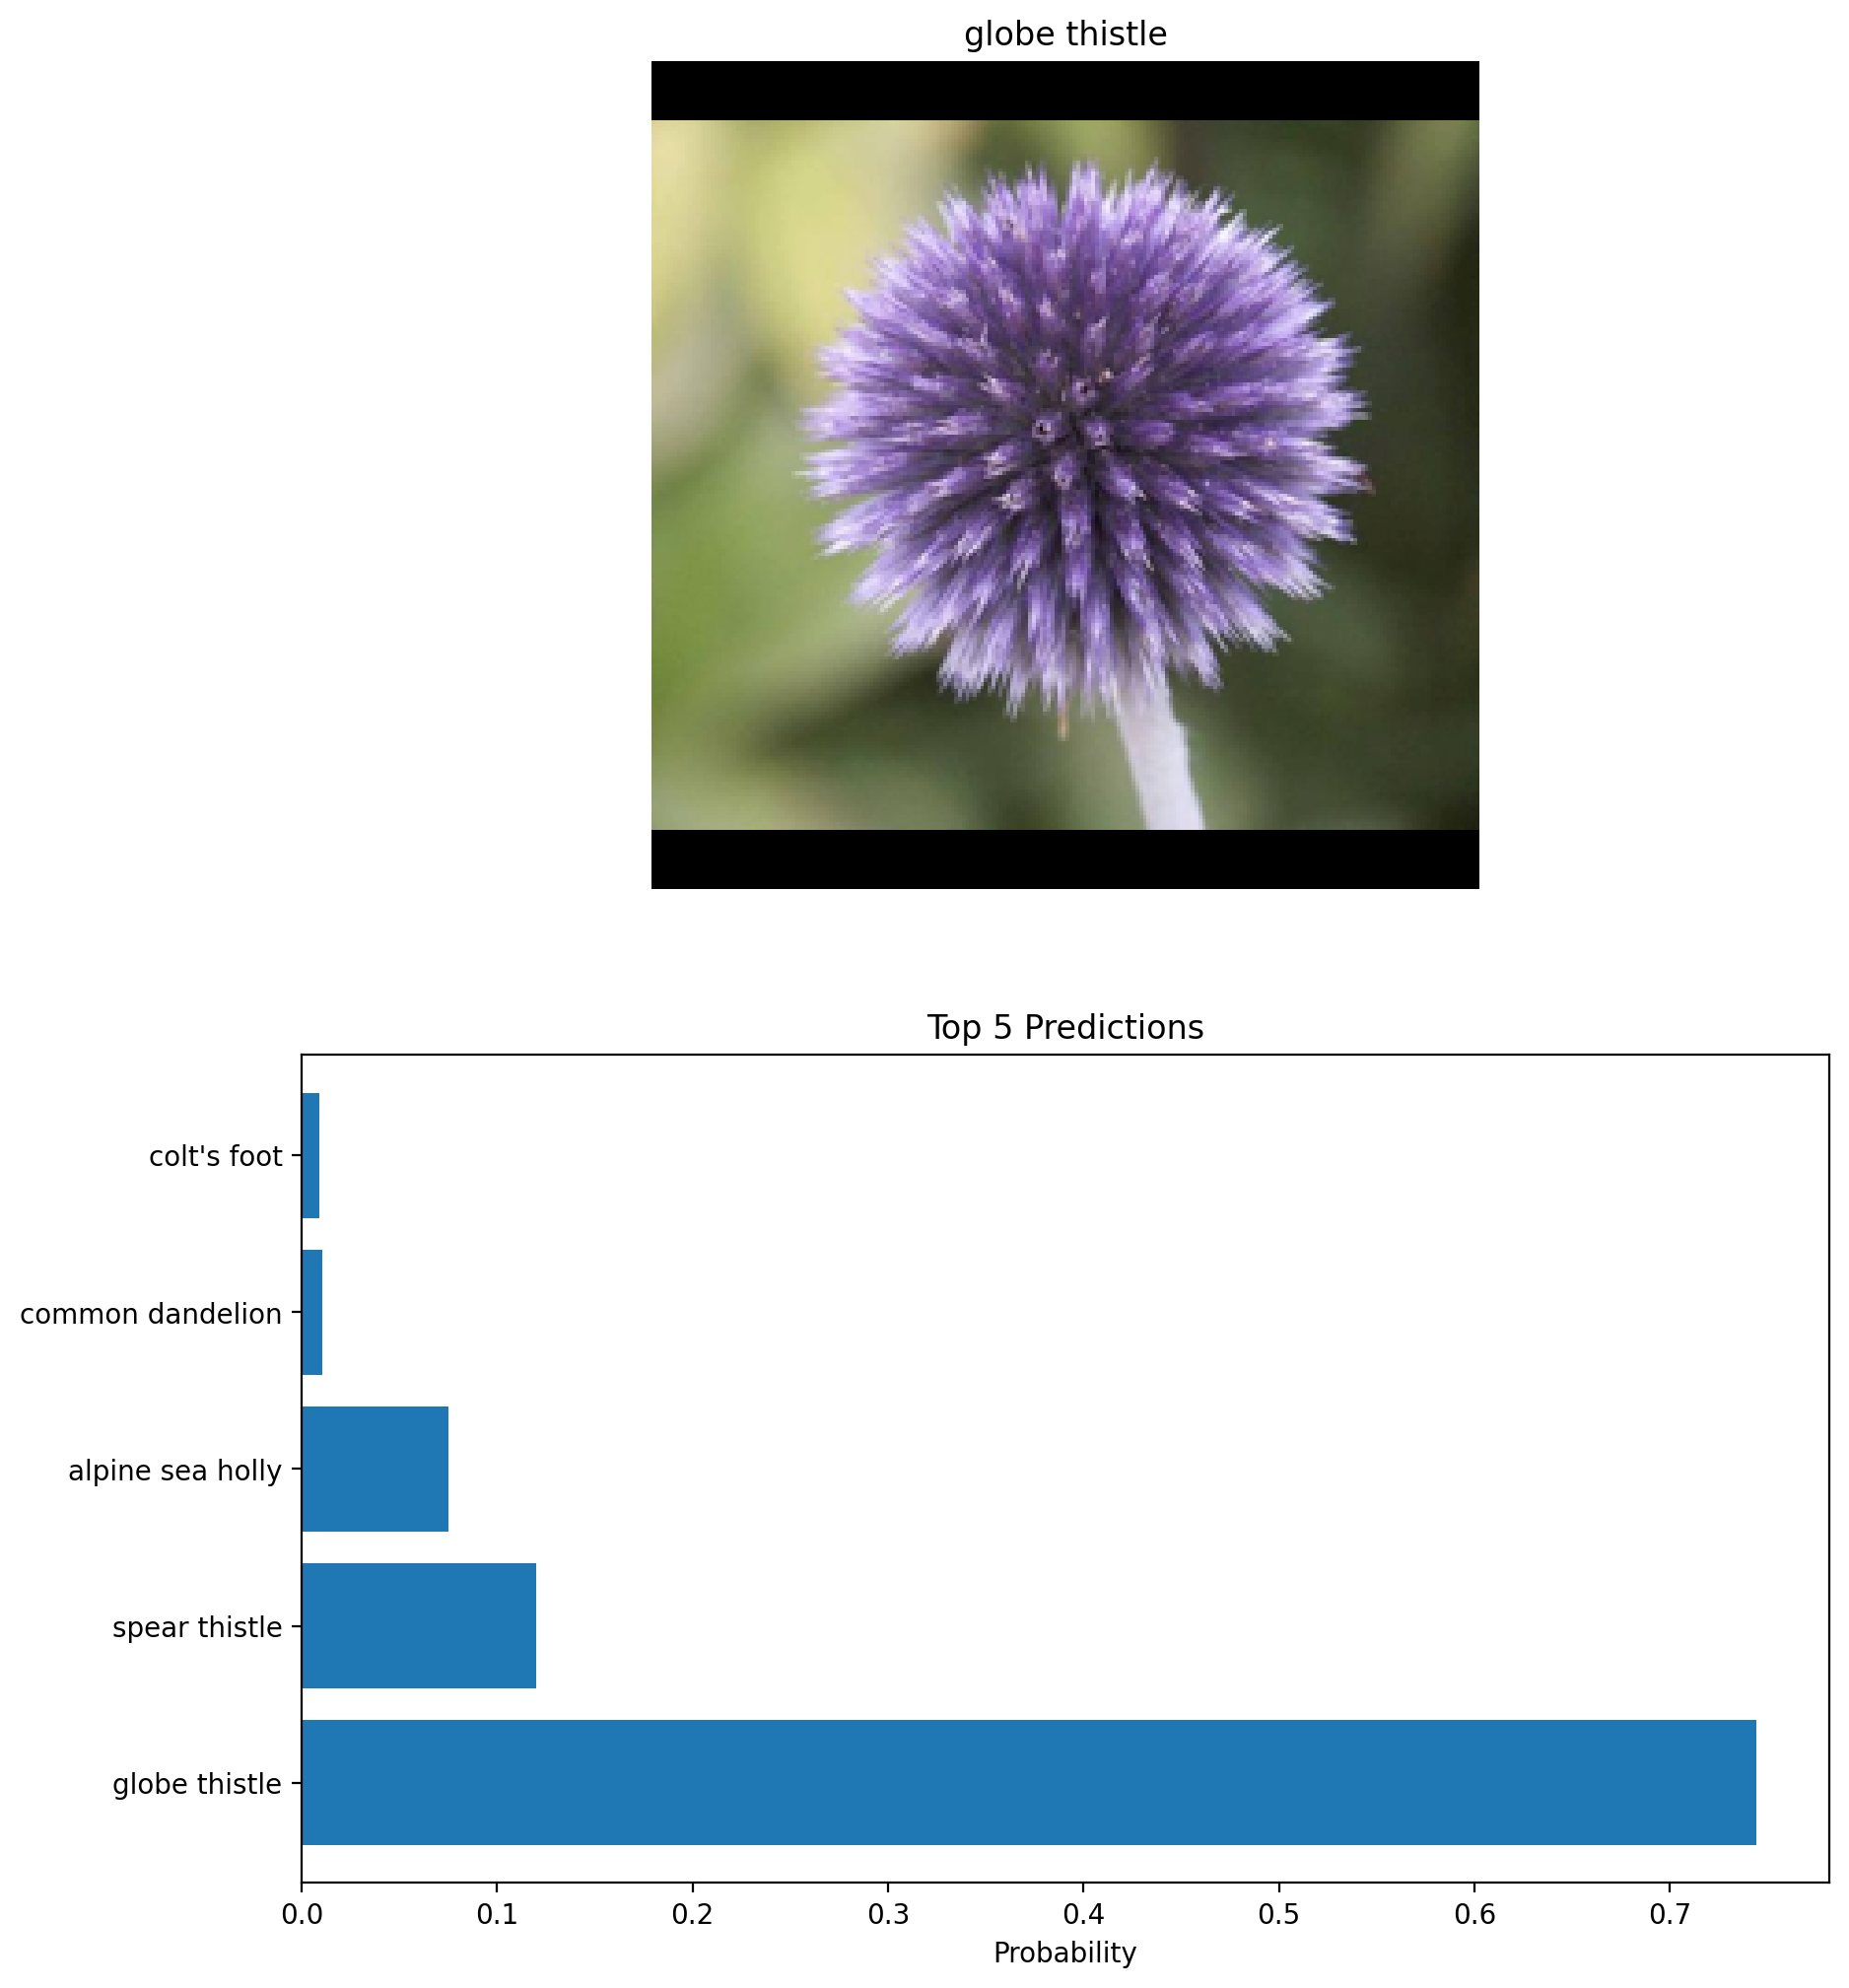

In [181]:
sanity_check('/kaggle/input/flower-data-set/flowers/flowers/train/10/image_07086.jpg', model_new)